<a href="https://colab.research.google.com/github/aminecloud9/PFE/blob/main/UNSW_NB15_Originaldata_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from __future__ import print_function
import numpy as np
np.random.seed(1337)  # for reproducibility
from keras.preprocessing import sequence
from keras.utils import np_utils
from keras.models import Sequential
from keras.optimizers import SGD
from keras.layers import Dense, Dropout, Activation, Embedding
from keras.layers import LSTM, SimpleRNN, GRU
from keras.datasets import imdb
from keras.utils.np_utils import to_categorical
from sklearn.metrics import (precision_score, recall_score,
                             f1_score, accuracy_score,mean_squared_error,mean_absolute_error)
from sklearn import metrics
from sklearn.preprocessing import Normalizer
import h5py
from keras import callbacks
from keras import callbacks
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from collections import Counter
from matplotlib import pyplot
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from numpy import where
import time

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
pip install git+https://github.com/artemmavrin/focal-loss.git

In [ ]:
pip install focal-loss

Download dataset

In [2]:
#data=pd.read_csv('/content/drive/MyDrive/CICIDS2017_multi_class_StandardScaler_NormalsationResults.csv')
#train_data = pd.read_csv('/content/drive/MyDrive/KDDTrain+.csv', header = None,nrows=1) # read just first line for columns
#columns = train_data.columns.tolist() # get the columns
#cols_to_use = columns[:len(columns)-1] 
train_data=pd.read_csv('/content/drive/MyDrive/UNSW_NB15_training.csv')
train_data = train_data.iloc[:, :-1]# drop the last one
test_data=pd.read_csv('/content/drive/MyDrive/UNSW_NB15_testing.csv')
test_data = test_data.iloc[:, :-1]# drop the last one

In [ ]:
train_data

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,252,254,1.415894e+04,8495.365234,0,0,24.295600,8.375000,30.177547,11.830604,255,621772692,2202533631,255,0.000000,0.000000,0.000000,43,43,0,0,1,0,1,1,1,1,0,0,0,1,1,0,Normal
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,62,252,8.395112e+03,503571.312500,2,17,49.915000,15.432865,61.426934,1387.778330,255,1417884146,3077387971,255,0.000000,0.000000,0.000000,52,1106,0,0,43,1,1,1,1,2,0,0,0,1,6,0,Normal
2,3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,62,252,1.572272e+03,60929.230470,1,6,231.875571,102.737203,17179.586860,11420.926230,255,2116150707,2963114973,255,0.111897,0.061458,0.050439,46,824,0,0,7,1,2,1,1,3,0,0,0,2,6,0,Normal
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,62,252,2.740179e+03,3358.622070,1,3,152.876547,90.235726,259.080172,4991.784669,255,1107119177,1047442890,255,0.000000,0.000000,0.000000,52,64,0,0,1,1,2,1,1,3,1,1,0,2,1,0,Normal
4,5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,254,252,8.561499e+03,3987.059814,2,1,47.750333,75.659602,2415.837634,115.807000,255,2436137549,1977154190,255,0.128381,0.071147,0.057234,53,45,0,0,43,1,2,2,1,40,0,0,0,2,39,0,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175336,175337,0.000009,udp,dns,INT,2,0,114,0,111111.107200,254,0,5.066666e+07,0.000000,0,0,0.009000,0.000000,0.000000,0.000000,0,0,0,0,0.000000,0.000000,0.000000,57,0,0,0,24,2,24,24,13,24,0,0,0,24,24,0,Generic
175337,175338,0.505762,tcp,-,FIN,10,8,620,354,33.612649,254,252,8.826286e+03,4903.492188,2,1,54.400111,66.980570,3721.068786,120.177727,255,3518776216,3453092386,255,0.099440,0.036895,0.062545,62,44,0,0,1,1,1,1,1,2,0,0,0,1,1,0,Shellcode
175338,175339,0.000009,udp,dns,INT,2,0,114,0,111111.107200,254,0,5.066666e+07,0.000000,0,0,0.009000,0.000000,0.000000,0.000000,0,0,0,0,0.000000,0.000000,0.000000,57,0,0,0,12,2,3,3,3,13,0,0,0,3,12,0,Generic
175339,175340,0.000009,udp,dns,INT,2,0,114,0,111111.107200,254,0,5.066666e+07,0.000000,0,0,0.009000,0.000000,0.000000,0.000000,0,0,0,0,0.000000,0.000000,0.000000,57,0,0,0,30,2,30,30,14,30,0,0,0,30,30,0,Generic


Data nemerisation

In [3]:

enc = OrdinalEncoder()
train_data[["proto"]] = enc.fit_transform(train_data[["proto"]])
test_data[["proto"]] = enc.fit_transform(test_data[["proto"]])

train_data[["service"]] = enc.fit_transform(train_data[["service"]])
test_data[["service"]] = enc.fit_transform(test_data[["service"]])

train_data[["state"]] = enc.fit_transform(train_data[["state"]])
test_data[["state"]] = enc.fit_transform(test_data[["state"]])


Train and test data formatting

In [4]:
train_X = train_data.values[:,:-1]
train_y = pd.factorize(train_data.values[:,-1])
test_X = test_data.values[:,:-1]
test_y = pd.factorize(test_data.values[:,-1])

Data scaling

In [5]:
scaler = StandardScaler()
train_X=scaler.fit_transform(train_X)
test_X = scaler.fit_transform(test_X)

Class=0, n=56000 (2800000.000%)
Class=1, n=1746 (87300.000%)
Class=2, n=2000 (100000.000%)
Class=3, n=18184 (909200.000%)
Class=4, n=1133 (56650.000%)
Class=5, n=10491 (524550.000%)
Class=6, n=33393 (1669650.000%)
Class=7, n=12264 (613200.000%)
Class=8, n=130 (6500.000%)
Class=9, n=40000 (2000000.000%)


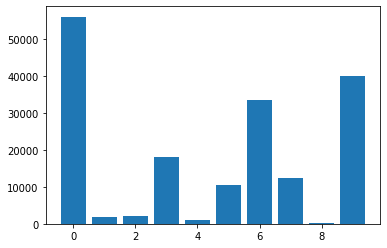

In [ ]:
# summarize distribution
counter = Counter(train_y[0])
for k,v in counter.items():
	per = v / len(train_y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
pyplot.bar(counter.keys(), counter.values())
pyplot.show()

Data augmentation

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

Counter({0: 56000, 1: 56000, 2: 56000, 3: 56000, 4: 56000, 5: 56000, 6: 56000, 7: 56000, 8: 56000, 9: 56000})


/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


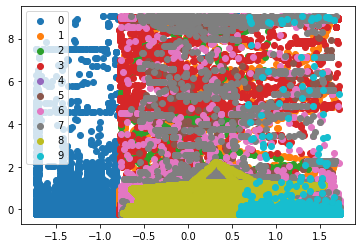

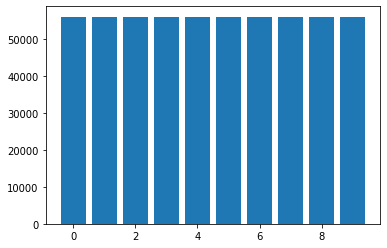

In [7]:
# Oversample and plot imbalanced dataset with SMOTE

# transform the dataset
oversample = SMOTE()
train_X, train_y = oversample.fit_resample(train_X, train_y[0])
# summarize the new class distribution
counter = Counter(train_y)
print(counter)
# scatter plot of examples by class label
for label, _ in counter.items():
	row_ix = where(train_y == label)[0]
	pyplot.scatter(train_X[row_ix, 0], train_X[row_ix, 1], label=str(label))
pyplot.legend()
pyplot.show()

pyplot.bar(counter.keys(), counter.values())
pyplot.show()

reshape input to be [samples, time steps, features]

In [8]:
import keras
#X_train = np.reshape(data.values[:,:-1].astype('float32'), (data.values[:,:-1].shape[0], 1, data.values[:,:-1].shape[1]))
X_train = np.reshape(train_X.astype('float32'), (train_X.shape[0], 1, train_X.shape[1]))
X_test = np.reshape(test_X.astype('float32'), (test_X.shape[0], 1, test_X.shape[1]))
#y_train = keras.utils.to_categorical(pd.factorize(data.values[:,77])[0],15)
y_train = keras.utils.to_categorical(train_y,10)
y_train = y_train.astype('int')
y_train = np.reshape(y_train,(y_train.shape[0],1,y_train.shape[1]))
y_test = keras.utils.to_categorical(test_y[0],10)
y_test = y_test.astype('int')
y_test = np.reshape(y_test,(y_test.shape[0],1,y_test.shape[1]))

Define the network

In [ ]:
#train_object_num=len(train_data)
#print(test[0])
#model training
batch_size = 1024
lrate = .1
DROPOUTRATE = .5
model=Sequential()
model.add(LSTM(X_train.shape[2],input_dim=X_train.shape[2],return_sequences=True,kernel_initializer='uniform',activation='relu'))
model.add(Dropout(DROPOUTRATE))
model.add(LSTM(32,kernel_initializer='uniform',return_sequences=True,activation='relu'))
model.add(Dropout(DROPOUTRATE))
model.add(LSTM(32,kernel_initializer='uniform',return_sequences=True,activation='relu'))
model.add(Dropout(DROPOUTRATE))
#model.add(Dense(256,activation='relu'))
model.add(Dropout(DROPOUTRATE))
model.add(Dense(128,activation='relu'))
model.add(Dropout(DROPOUTRATE))
model.add(Dense(64,activation='relu'))
model.add(Dropout(DROPOUTRATE))
model.add(Dense(16,activation='relu'))
model.add(Dropout(DROPOUTRATE))
model.add(Dense(y_train.shape[2],activation='sigmoid'))
opt = SGD(lr=lrate)
model.compile(loss='binary_crossentropy',optimizer='NADAM',metrics=['accuracy'])
model.summary()
start_time = time.time()
history = model.fit(X_train,y_train,validation_split=.3,epochs=100,batch_size=batch_size,verbose=1)
finish_time = time.time() - start_time
#model.save("/content/drive/My Drive/model_CICIDS_brute_data_valsplit.3.h5")

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 43)          14964     
_________________________________________________________________
dropout (Dropout)            (None, None, 43)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 32)          9728      
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 32)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 32)          8320      
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 32)          0         
_________________________________________________________________
dropout_3 (Dropout)          (None, None, 32)         

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
loss, accuracy = model.evaluate(X_test,y_test)
print("\nLoss: %.2f, Accuracy: %.2f%%" % (loss, accuracy*100))
y_pred = model.predict_classes(X_train)
target_names = ['Normal', 'Dos', 'Probe','R2L', 'U2R']
print(classification_report(y_true = np.transpose(test_y[0]), y_pred = y_pred))
#print(accuracy_score(y_true = np.transpose(test_y[0]), y_pred = y_pred))
print("execution time :  ",finish_time)

saving model

In [ ]:
model.save("/content/drive/MyDrive/NSL-KDD_42norm_results_5Dense_po_Dropout_200epoch_1024batch_model.h5")

In [ ]:
from keras.models import load_model
#model = load_model('/content/drive/MyDrive/NSL-KDD_results_SimpleRNN_model.hdf5')
loss, accuracy = model.evaluate(X_test, y_test)
print("\nLoss: %.2f, Accuracy: %.2f%%" % (loss, accuracy*100))

#print("--- %s seconds ---",finish_time)
y_pred = model.predict(X_train)
#np.savetxt('/content/drive/MyDrive/NSL-KDD_results_SimpleRNN_predicted.txt', np.transpose([y_test,y_pred]), fmt='%s')

2573/2573 [==============================] - 4s 2ms/step - loss: 6.5163 - accuracy: 0.3234

Loss: 6.52, Accuracy: 32.34%


In [ ]:
42 col pca 80% : b_s=256 epochs= 300 Lstm(32,32)->Dense(256,128,64,ytrain.shape(2))   ->   accuracy = 62.8%


24 col normalisé : b_s=1024 epochs= 100 Lstm(32,32)->Dense(256,128,64,16,ytrain.shape(2))   ->   accuracy = 83.73%
24 col pca 80% : b_s=1024 epochs= 100 Lstm(32,32)->Dense(256,128,64,16,ytrain.shape(2))   ->   accuracy = 40.28%
42 col normalisé : b_s=1024 epochs= 100 Lstm(32,32)->Dense(256,128,64,16,ytrain.shape(2))   ->   accuracy = 48.52%
42 col pca 80% : b_s=1024 epochs= 100 Lstm(32,32)->Dense(256,128,64,16,ytrain.shape(2))   ->   accuracy = 45.22%


In [ ]:
batch_size= 1024
lrate = 0.1
DROPOUTRATE = 0.3
model = Sequential()
model.add(Dense(X_train.shape[2], input_dim=X_train.shape[2], activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(DROPOUTRATE))
model.add(Dense(768, activation='relu'))
model.add(Dropout(DROPOUTRATE))
model.add(Dense(512, activation='relu'))
model.add(Dropout(DROPOUTRATE))
model.add(Dense(256, activation='relu'))
model.add(Dropout(DROPOUTRATE))
model.add(Dense(128, activation='relu'))
model.add(Dropout(DROPOUTRATE))
model.add(Dense(y_train.shape[2], activation='softmax'))
	# compile model
opt = SGD(lr=lrate)
#loss = categorical_focal_loss([67343,45927,995,11656,52])
model.compile(loss= 'categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
# fit model
history = model.fit(X_train, y_train, validation_split=.3,batch_size=batch_size, epochs=10, verbose=1)

Epoch 1/10
383/383 [==============================] - 73s 189ms/step - loss: 1.3678 - accuracy: 0.5234 - val_loss: 3.4806 - val_accuracy: 0.1649
Epoch 2/10
383/383 [==============================] - 71s 187ms/step - loss: 0.9487 - accuracy: 0.6404 - val_loss: 3.4781 - val_accuracy: 0.1765
Epoch 3/10
383/383 [==============================] - 71s 187ms/step - loss: 0.8776 - accuracy: 0.6625 - val_loss: 3.3949 - val_accuracy: 0.1920
Epoch 4/10
383/383 [==============================] - 71s 186ms/step - loss: 0.8356 - accuracy: 0.6779 - val_loss: 3.4196 - val_accuracy: 0.2177
Epoch 5/10
383/383 [==============================] - 72s 187ms/step - loss: 0.8014 - accuracy: 0.6901 - val_loss: 3.4427 - val_accuracy: 0.2463
Epoch 6/10
383/383 [==============================] - 72s 187ms/step - loss: 0.7801 - accuracy: 0.6994 - val_loss: 3.2567 - val_accuracy: 0.2503
Epoch 7/10
383/383 [==============================] - 72s 187ms/step - loss: 0.7626 - accuracy: 0.7057 - val_loss: 3.0615 - val_ac

Text(0.5, 1.0, 'lrate=0.1')

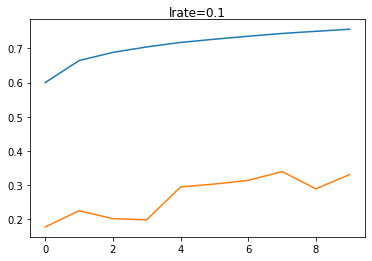

In [ ]:
from matplotlib import pyplot
# plot accuracy
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.title('lrate='+str(lrate), pad=-50)


Text(0.5, 1.0, 'lrate=0.1')

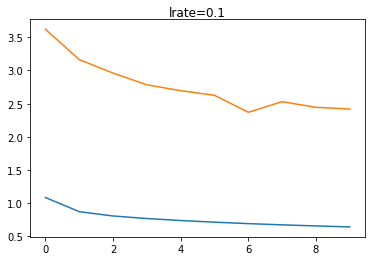

In [ ]:

# plot leoss
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.title('lrate='+str(lrate), pad=-50)